In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import time

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

branched_model_path = os.path.join(models_base_path, "mnist_continuous_alldigits/2/epoch_90_ckpt.pth")

In [5]:
# Define the branches
classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

classes_049 = [0, 4, 9]
branch_defs_049 = [
    ((0, 4, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 9), 0.35, 0.5),
    ((4,), 0, 0.35),
    ((9,), 0, 0.35)
]

classes_0497 = [0, 4, 9, 7]
branch_defs_0497 = [
    ((0, 4, 7, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 7, 9), 0.38, 0.5),
    ((7,), 0, 0.38),
    ((4, 9), 0.35, 0.38),
    ((4,), 0, 0.35),
    ((9,), 0, 0.35)
]

classes_7 = [7]
branch_defs_7 = [
    ((7,), 0, 0.38)
]

input_shape = (1, 28, 28)

In [6]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [7]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/mnist_efficiency"

os.makedirs(out_path, exist_ok=True)

### Create data loader

In [8]:
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [9]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import models

In [10]:
branched_model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat, branched_model_path
).to(DEVICE)

### Generating multiple digit classes

In [11]:
# Sample each class individually without taking advantage of branches
num_linear_trials = 10
linear_times = []
for _ in range(num_linear_trials):
    time_a = time.time()
    for class_to_sample in classes:
        print("Sampling class: %s" % class_to_sample)
        generate.generate_continuous_branched_samples(
            branched_model, sde, class_to_sample,
            lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
            sampler="pc", t_limit=t_limit, num_steps=1000
        )
    time_b = time.time()
    time_taken = time_b - time_a
    linear_times.append(time_taken)
    print("Total time taken: %ds" % time_taken)
print("Average time taken: %.2f +/- %.2f" % (np.mean(linear_times), np.std(linear_times) / np.sqrt(len(linear_times))))

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Total time taken: 79s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Total time taken: 79s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Total time taken: 78s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Total time taken: 78s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Total time t

In [12]:
# Sample each digit by taking advantage of branches
num_branched_trials = 10
branched_times = []

# Sort the branches by starting time point (in reverse order), and generate along those
# branches, caching results; this guarantees that we will always find a cached batch
# (other than the first one)
cache = {}
sorted_branch_defs = sorted(branch_defs, key=(lambda t: -t[1]))

for _ in range(num_branched_trials):
    time_a = time.time()
    # First branch
    print("Sampling branch 1/%d" % len(sorted_branch_defs))
    branch_def = sorted_branch_defs[0]
    samples = generate.generate_continuous_branched_samples(
        # Specify arbitrary class
        branched_model, sde, branch_def[0][0],
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
        sampler="pc", t_limit=branch_def[2], t_start=branch_def[1],
        num_steps=int(1000 * (branch_def[2] - branch_def[1]))
    )
    for class_i in branch_def[0]:
        cache[class_i] = (branch_def[1], samples)

    for i, branch_def in enumerate(sorted_branch_defs[1:]):
        print("Sampling branch %d/%d" % (i + 2, len(sorted_branch_defs)))
        cached_time, cached_samples = cache[branch_def[0][0]]
        assert cached_time == branch_def[2]
        samples = generate.generate_continuous_branched_samples(
            branched_model, sde, branch_def[0][0],
            lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
            sampler="pc", t_limit=branch_def[2], t_start=branch_def[1],
            num_steps=int(1000 * (branch_def[2] - branch_def[1])),
            initial_samples=cached_samples
        )
        for class_i in branch_def[0]:
            cache[class_i] = (branch_def[1], samples)

    time_b = time.time()
    time_taken = time_b - time_a
    branched_times.append(time_taken)
    print("Total time taken: %ds" % time_taken)
print("Average time taken: %.2f +/- %.2f" % (np.mean(branched_times), np.std(branched_times) / np.sqrt(len(branched_times))))

Sampling branch 1/19
Sampling branch 2/19
Sampling branch 3/19
Sampling branch 4/19
Sampling branch 5/19
Sampling branch 6/19
Sampling branch 7/19
Sampling branch 8/19
Sampling branch 9/19
Sampling branch 10/19
Sampling branch 11/19
Sampling branch 12/19
Sampling branch 13/19
Sampling branch 14/19
Sampling branch 15/19
Sampling branch 16/19
Sampling branch 17/19
Sampling branch 18/19
Sampling branch 19/19
Total time taken: 37s
Sampling branch 1/19
Sampling branch 2/19
Sampling branch 3/19
Sampling branch 4/19
Sampling branch 5/19
Sampling branch 6/19
Sampling branch 7/19
Sampling branch 8/19
Sampling branch 9/19
Sampling branch 10/19
Sampling branch 11/19
Sampling branch 12/19
Sampling branch 13/19
Sampling branch 14/19
Sampling branch 15/19
Sampling branch 16/19
Sampling branch 17/19
Sampling branch 18/19
Sampling branch 19/19
Total time taken: 37s
Sampling branch 1/19
Sampling branch 2/19
Sampling branch 3/19
Sampling branch 4/19
Sampling branch 5/19
Sampling branch 6/19
Sampling bra

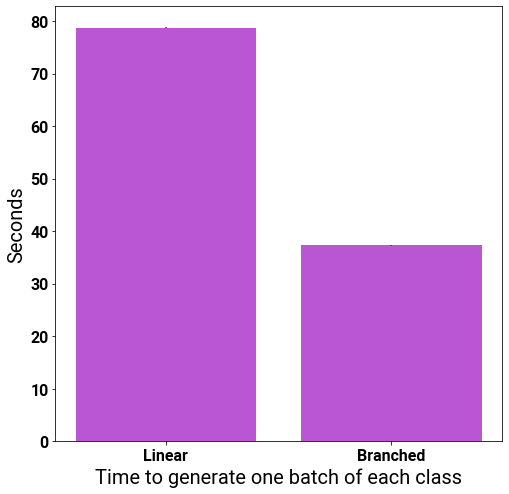

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
labels = ["Linear", "Branched"]
times = [np.mean(linear_times), np.mean(branched_times)]
errors = [np.std(linear_times) / np.sqrt(num_linear_trials), np.std(branched_times) / np.sqrt(num_branched_trials)]
ax.bar(labels, times, color="mediumorchid")
ax.errorbar(labels, times, yerr=errors, fmt="none", color="darkmagenta")
ax.set_xlabel("Time to generate one batch of each class")
ax.set_ylabel("Seconds")
plt.show()
fig.savefig(
    os.path.join(out_path, "mnist_efficiency.svg"),
    format="svg"
)